# gQuant - Making Quantitative Analysis Faster

## Background
By definition, **Quantitative Finance** is the use of mathematical models and large datasets to analyze financial markets and securities, requiring massive computation to extract insight from the data. 

Many data science toolkits have been developed to help data scientists to manipulate the data. It starts with scalar number computations at the beginning. Later, the development of [Numpy](https://www.numpy.org) library helps to operate the numbers at vectors, and the popular [Pandas](https://pandas.pydata.org) library operates at a dataframe level. Manipulating data at a high level brings productivity gain for data scientists in quantitative finance.

However, the amount of collected data is increasing exponentially over time.  Also, more and more machine learning and statistical models are being developed. As a result, data scientists are facing new challenges hard to deal with traditional data science libraries.

It is very time-consuming for CPUs to crunch massive amount of data and compute the complicated data science models. Large data set requires distributed computation, which is too complicated for data scientists to adopt.

As a consequence, the quantitative workflow has become more complicated than ever. It integrates massive data from different sources, requiring multiple iterations to obtain significative results. 

**gQuant** has been developed to address all these challenges by organizing dataframes into graphs. It introduces the idea of **dataframe-flow**, which manipulates dataframes at graph level. An **acyclic directed graph** is defined, where the nodes are dataframe processors and the edges are the directions of passing resulting dataframes.

With a graph approach, quant's workflow is described at a high level, letting quant analysts address the complicated workflow challenge.

It is GPU-accelerated by leveraging [RAPIDS.ai](https://rapids.ai) technology and has **Multi-GPU and Multi-Node support**.

We can get orders of magnitude performance boosts compared to CPU. gQuant dataframe-flow is **dataframe agnostic**, and can flow:
- Pandas dataframe, computed in the CPU.
- cuDF dataframe, computed in the GPU and producing the same result but much faster.
- dask_cuDF dataframe, being the computation automatically executed on multiple nodes and multiple GPUs.

## Download example datasets

Before getting started, let's download the example datasets if not present.

In [1]:
! ((test ! -f './data/stock_price_hist.csv.gz' ||  test ! -f './data/security_master.csv.gz') && \
  cd .. && bash download_data.sh) || echo "Dataset is already present. No need to re-download it."

Dataset is already present. No need to re-download it.


## The toy example
In this notebook, we will use a simple toy example to show how easy it is to accelerate the quant workflow in the GPU.

To mimic the end-to-end quantitative analyst task, we are going to backtest a simple mean reversion trading strategy.

The workflow includes following steps:

1. Load the 5000 end-of-day stocks CSV data into the dataframe.
2. Add rate of return feature to the dataframe.
3. Clean up the data by removing low volume stocks and extreme rate of returns stocks.
4. Compute the slow and fast exponential moving average and compute the trading signal based on it.
5. Run backtesting and compute the returns from this strategy for each of the days and stock symbols.
6. Run a simple portfolio optimization by averaging the stocks together for each of the trading days.
7. Compute the sharpe ratio and cumulative return results.

The whole workflow can be organized into a computation graph, which is described in a **yaml** file.

Here is snippet of the yaml file:

In [2]:
!head -n 18 ../task_example/port_trade.yaml
print("...")

- id:  load_csv_data
  type: CsvStockLoader
  conf:
    path: ./data/stock_price_hist.csv.gz
  inputs: []
- id: sort
  type: SortNode
  conf:
    keys:
      - asset
      - datetime
  inputs:
    -  load_csv_data
- id: add_return
  type: ReturnFeatureNode
  conf: {}
  inputs:
    - sort
...


Each node is composed of:
- a unique id,
- a node type, 
- configuration parameters
- from zero to many input nodes ids.

gQuant's `load_taskgraph` and `viz_graph` takes this yaml file, and wires it into a graph.

We  use nxpd's `draw` method to visualize it.

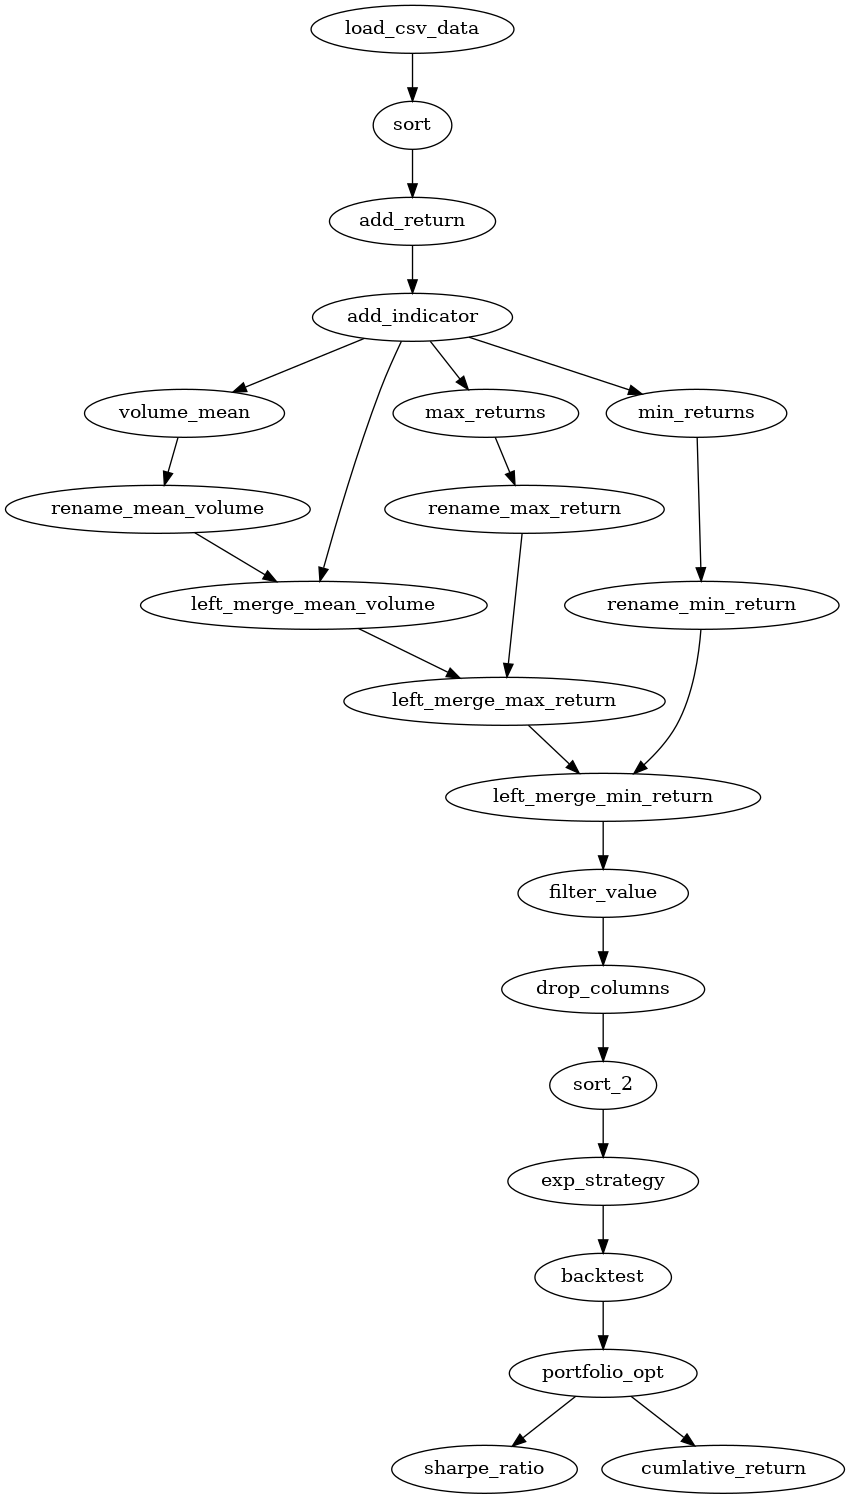

In [3]:
import sys; sys.path.insert(0, '..')
from gquant.dataframe_flow import TaskGraph

task_graph = TaskGraph.load_taskgraph('../task_example/port_trade.yaml')
task_graph.draw(show='ipynb')

It can be observed that the graph above represents the computation steps described at the beginning of this section. 

## Node implementation
gQuant implementation includes some common nodes, useful for quantitative finance. With the help of [Numba](https://numba.pydata.org) library, we have implemented more than 30 technical indicators used in computing trading signals. All of them computed in the GPU.

However, gQuant's goal is not to be comprehensive for quant applications. It provides a framework that is easy for anyone to implement his own nodes in the gQuant.

Data scientists only need to override two methods in the parent class `Node`:
- `columns_setup`
- `process`

`columns_setup` method  is used to define the required column names and types for both input and output dataframes.

`process` method takes input dataframes and computes the output dataframe. 

In this way, dataframes are strongly typed, and errors can be detected early before the time-consuming computation happens.

Here is the code example for implementing `MaxNode`, which is to compute the maximum value for a specified column in the dataframe.

In [4]:
from gquant.dataframe_flow import Node

class MaxNode(Node):
    def columns_setup(self):
        """
            This method is used to define:
               - required input dataframes column names and types,
               - column names and types of the output dataframe.

            In this example, the input dataframe must have an `asset` column of type `int64`.

            The output dataframe will consist of two columns:
               - The 1st column will be named with the value of the config parameter `@value`,
                 and its datatype will be `float64`.
               - The 2nd column will be named `asset` and its datatype will be `int64`.
        """
        self.required = {"asset": "int64"}
        self.retention = {self.conf['column']: "float64",
                          "asset": "int64"}    
    
    def process(self, inputs):
        """
            This method is used to calculate the maximum value of the `asset` column from the
            input dataframe.

            The input and output dataframes structure are defined in the `columns_setup` method.
        """
        input_df = inputs[0]
        max_column = self.conf['column']
        volume_df = input_df[[max_column, "asset"]].groupby(["asset"]).max().reset_index()
        volume_df.columns = ['asset', max_column]
        
        return volume_df

In case that there is no direct dataframe method for a particular logic, a Numba GPU kernel can be used to implement it. Some examples of customized GPU kernels in Numba can be found [here](https://github.com/rapidsai/gQuant/blob/master/notebooks/05_customize_nodes.ipynb).

If we use customized GPU kernel functions inside the `process` method to process the dataframe instead of _normal_ dataframe API functions calls,  we need to add `self.delayed_process = True` in the `columns_setup` method to let gQuant handle the dask graph integration problem. If we use  _normal_ dataframe API functions inside the `process` method, nothing needs to be done as `self.delayed_process = False` by default.

gQuant automatically handles the complication of including a customized GPU kernel node into the Dask computation graph.

## Running a task graph
gQuant graph is evaluated by specifying the output nodes and input nodes replacement.

In [5]:
import os
import warnings; warnings.simplefilter("ignore")

# Define some constants for the data filters.
# If using a GPU of 32G memory, you can safely 
# set the `min_volume` to 5.0
min_volume = 400.0
min_rate = -10.0
max_rate = 10.0

In [6]:
%%time
action = "load" if os.path.isfile('./.cache/load_csv_data.hdf5') else "save"
o_gpu = task_graph.run(
            outputs=['sharpe_ratio', 'cumlative_return', 'load_csv_data', 'sort_2'],
            replace={'filter_value': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]},
                     'load_csv_data': {action: True}}, profile=True)

gpu_input_cached = o_gpu[2]  # 'load_csv_data' node output
gpu_strategy_cached = o_gpu[3]  # 'sort_2' node output

id:sort process time:0.144s
id:add_return process time:1.137s
id:add_indicator process time:0.041s
id:volume_mean process time:0.112s
id:rename_mean_volume process time:0.001s
id:left_merge_mean_volume process time:2.703s
id:max_returns process time:0.025s
id:rename_max_return process time:0.001s
id:left_merge_max_return process time:0.027s
id:min_returns process time:0.022s
id:rename_min_return process time:0.001s
id:left_merge_min_return process time:0.041s
id:filter_value process time:0.344s
id:drop_columns process time:0.012s
id:sort_2 process time:0.060s
id:exp_strategy process time:0.940s
id:backtest process time:0.043s
id:portfolio_opt process time:0.040s
id:sharpe_ratio process time:0.001s
id:cumlative_return process time:2.090s
CPU times: user 7.89 s, sys: 2.1 s, total: 9.99 s
Wall time: 10.2 s


In the example above, `filter_value` node parameters are overridden by the `replace` arguments.

`o_gpu` will contain the outputs of four nodes: `sharpe_ratio`, `cumlative_return`, `load_csv_data`, `sort_2`.

Similarly, the output from `load_csv_data` and `sort_2` nodes will be cached stored in `gpu_input_cached` and `strategy_cached` variables for later use. 

`filter_value` node configuration is set up to filter out the stocks that are not suitable for backtesting. It will discard stocks according to the values stored in `min_volume`, `min_rate`, and `max_rate` variables.

In [7]:
print("{} stocks in original dataset.".format(len(gpu_input_cached['asset'].unique())))
print("{} stocks remaining after filtering.".format(len(gpu_strategy_cached['asset'].unique())))

5052 stocks in original dataset.
1558 stocks remaining after filtering.


[bqplot](https://github.com/bloomberg/bqplot) library is used to visualize the backtesting results in the JupyterLab notebooks. 

In [8]:
# define the function to format the plots
def plot_figures(outputs):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    sharpe_number = outputs[0]
    cum_return = outputs[1]
    cum_return.layout.height = figure_height
    cum_return.layout.width = figure_width
    cum_return.title = 'P & L %.3f' % (sharpe_number)
    return cum_return

plot_figures(o_gpu)

Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale(), side='left'), Axis(l…

This toy strategy gets a Sharpe ratio 0.338 without considering the transaction cost. Nice! 

Next, we are going to compare the performance difference between CPU and GPU. The same computation graph can be used to flow the CPU Pandas dataframe with a few changes:

1. the root node need to be changed to load the Pandas dataframe
2. a few computation nodes that use Numba GPU kernels need to be changed to use CPU implementations 

Those nodes that uses compatible dataframe API calls can be leaved as is. We can simply change the Node type in the graph to change the implementations:

In [9]:
%%time
o_cpu = task_graph.run(
            outputs=['sharpe_ratio', 'cumlative_return', 'load_csv_data', 'sort_2'],
            replace={'load_csv_data': {"type": "PandasCsvStockLoader"},
                     'filter_value': {"conf": [{"column": "volume_mean", "min": min_volume},
                                               {"column": "returns_max", "max": max_rate},
                                               {"column": "returns_min", "min": min_rate}]},
                     'add_return': {"type": "CpuReturnFeatureNode"},
                     'add_indicator': {"type": "CpuAssetIndicatorNode"},
                     'exp_strategy': {"type": "CpuPortExpMovingAverageStrategyNode"}}, profile=True)

cpu_input_cached = o_cpu[2]  # 'load_csv_data' node output
cpu_strategy_cached = o_cpu[3]  # 'sort_2' node output

id:load_csv_data process time:88.344s
id:sort process time:5.336s
id:add_return process time:20.408s
id:add_indicator process time:6.722s
id:volume_mean process time:0.347s
id:rename_mean_volume process time:0.002s
id:left_merge_mean_volume process time:4.962s
id:max_returns process time:0.346s
id:rename_max_return process time:0.001s
id:left_merge_max_return process time:4.598s
id:min_returns process time:0.347s
id:rename_min_return process time:0.002s
id:left_merge_min_return process time:4.709s
id:filter_value process time:0.928s
id:drop_columns process time:0.068s
id:sort_2 process time:1.100s
id:exp_strategy process time:11.242s
id:backtest process time:0.025s
id:portfolio_opt process time:0.300s
id:sharpe_ratio process time:0.001s
id:cumlative_return process time:0.077s
CPU times: user 2min 23s, sys: 6.82 s, total: 2min 30s
Wall time: 2min 29s


In [10]:
plot_figures(o_cpu)

Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale()), Axis(label='Time', …

## Benchmarks

While running this notebook, we have obtained the following results:

- 181.00 seconds to run in CPU (Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz).
-   9.06 seconds to run in GPU (NVIDIA v100).

We get ~20x speed up by using GPU and GPU dataframes, compared to CPU and CPU dataframes.

Note, the input nodes load the dataframes from the cache variables to save the disk IO time.

## Distributed computation

Running this toy example in a Dask distributed environment is super easy, as gQuant operates at dataframe level.

We mostly need to swap cuDF dataframes to **dask_cuDF** dataframes.

Let's begin by starting the Dask local cluster environment for distributed computation.

Dask provides a web-based dashboard to help to track progress, identify performance issues, and debug failures. To learn more about Dask dashboard, just follow this [link](https://distributed.dask.org/en/latest/web.html).

In [11]:
# Start the Dask local cluster environment for distrubuted computation
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45865 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


Then, we will split the large dataframe into small pieces to be loaded by different workers in the cluster.

Notice this step is need only if the dataset is not split in multiple files yet.

In [12]:
import dask.dataframe as dd
import os

os.makedirs('many-small', exist_ok=True)
dd.from_pandas(cpu_input_cached.set_index('asset'), npartitions=8).reset_index().to_csv('many-small/*.csv', index=False)

['/Projects/gQuant/notebooks/many-small/0.csv',
 '/Projects/gQuant/notebooks/many-small/1.csv',
 '/Projects/gQuant/notebooks/many-small/2.csv',
 '/Projects/gQuant/notebooks/many-small/3.csv',
 '/Projects/gQuant/notebooks/many-small/4.csv',
 '/Projects/gQuant/notebooks/many-small/5.csv',
 '/Projects/gQuant/notebooks/many-small/6.csv',
 '/Projects/gQuant/notebooks/many-small/7.csv']

The distributed computation is turned on by changing the root node type:

In [13]:
%%time
o_dask = task_graph.run(
            outputs=['sharpe_ratio', 'cumlative_return', 'load_csv_data', 'sort_2'],
            replace={'load_csv_data': {"type": "DaskCsvStockLoader",
                                       "conf": {"path": "many-small"}},
                     'filter_value': {"conf": [{"column": "volume_mean", "min": min_volume},
                                               {"column": "returns_max", "max": max_rate},
                                               {"column": "returns_min", "min": min_rate}]}}, profile=True)

dask_input_cached = o_dask[2]  # 'load_csv_data' node output
dask_strategy_cached = o_dask[3]  # 'sort_2' node output

id:load_csv_data process time:0.031s
id:volume_mean process time:0.472s
id:rename_mean_volume process time:0.012s
id:left_merge_mean_volume process time:0.159s
id:max_returns process time:0.055s
id:rename_max_return process time:0.012s
id:left_merge_max_return process time:0.026s
id:min_returns process time:0.046s
id:rename_min_return process time:0.013s
id:left_merge_min_return process time:0.025s
id:filter_value process time:0.046s
id:backtest process time:0.037s
id:portfolio_opt process time:0.420s
id:sharpe_ratio process time:8.605s
id:cumlative_return process time:12.172s
CPU times: user 51.5 s, sys: 1.41 s, total: 52.9 s
Wall time: 2min 12s


In [14]:
plot_figures(o_dask)

Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale()), Axis(label='Time', …

Again, it produces the same results. However, the performance is not better than in the other scenarios.

Distributed computation only makes sense if we have a very large dataset that cannot be fit into one GPU.

In this example, the dataset is small enough to be loaded into a single GPU. The between-GPU communication overhead dominates in the computation.

## Strategy parameter search
Quantitative analysts often need to explore different parameters for their trading strategy.

gQuant speeds up this iterative exploration process by using cached dataframes and sub-graphs evaluation.

To find the optimal parameters for this toy mean reversion strategy, we only need the dataframe from `sort_2` node, which is cached in the `gpu_strategy_cached` variable.

Because the GPU computation is so fast, we can make the parameter exploration interactive in the JupyterLab notebook:

In [15]:
import ipywidgets as widgets

para_selector = widgets.IntRangeSlider(value=[10, 30],
                                       min=3,
                                       max=60,
                                       step=1,
                                       description="MA:",
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True)


def para_selection(*stocks):
    with out:
        para1 = para_selector.value[0]
        para2 = para_selector.value[1]
        o = task_graph.run(
                outputs=['sharpe_ratio', 'cumlative_return'],
                replace={'sort_2': {"load": gpu_strategy_cached},
                         'exp_strategy': {'conf':  {'fast': para1,
                                                    'slow': para2}},
                         'filter_value': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]}})

        figure_combo = plot_figures(o)
        w.children = (w.children[0], figure_combo,)


out = widgets.Output(layout={'border': '1px solid black'})
para_selector.observe(para_selection, 'value')
selectors = widgets.HBox([para_selector])
w = widgets.VBox([selectors])
w